# Main Aim: Predicts Next 30 day close market rates.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
sns.set()
import warnings
warnings.filterwarnings("ignore")

## Reading Data

In [2]:
data = pd.read_csv("Amazon.csv")

In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


## Ploting Data

In [4]:
plot_features = data.copy()
plot_features.index = plot_features['Date']
plot_features.drop('Date', axis=1, inplace=True)

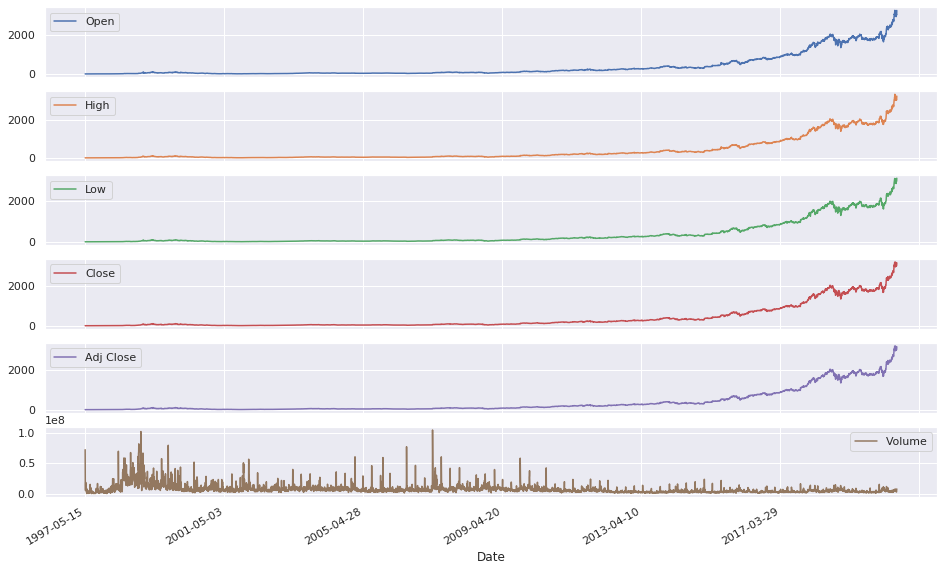

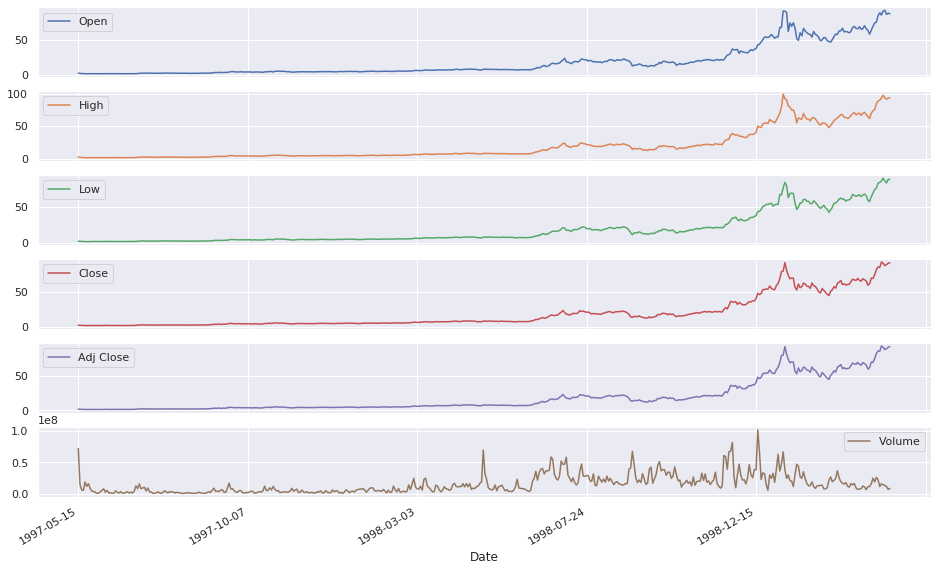

In [5]:
plot_features.plot(subplots=True, figsize=[16,10])
plt.show()

#ploting first 480 days
plot_features[:480].plot(subplots=True, figsize=[16,10])
plt.show()

## Data Preparation

In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5842.000000,5842.000000,5842.000000,5842.000000,5842.000000,5.842000e+03
mean,372.707174,376.921392,368.114569,372.746660,372.746660,7.519048e+06
std,585.571802,591.766458,578.660700,585.607655,585.607655,7.282683e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,37.955001,38.547501,37.207500,37.927499,37.927499,3.684900e+06
50%,83.428749,84.945000,81.656250,83.459999,83.459999,5.657200e+06
75%,359.729988,363.439987,356.280006,360.047501,360.047501,8.533400e+06
max,3251.060059,3344.290039,3151.000000,3200.000000,3200.000000,1.043292e+08


In [7]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [8]:
final_data = data['Close'][4017:]
final_data

4017     258.049988
4018     255.720001
4019     257.730011
4020     258.679993
4021     260.160004
           ...     
5837    3055.209961
5838    3000.330078
5839    3033.530029
5840    3051.879883
5841    3164.679932
Name: Close, Length: 1825, dtype: float64

### Spliting Data

In [9]:
train_data = final_data[:int(len(final_data) * 0.90)]
test_data = final_data[int(len(final_data) * 0.90):]

### Scaling Data

In [10]:
scale = MinMaxScaler(feature_range=(0, 1))

In [11]:
scale.fit(np.array(train_data).reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
train_data = scale.transform(np.array(train_data).reshape(-1,1))
test_data = scale.transform(np.array(test_data).reshape(-1,1))

### Reshaping Data

In [13]:
def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i : (i + time_step), 0]
        x.append(a)
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

In [14]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [15]:
x_train.shape, y_train.shape

((1541, 100), (1541,))

In [16]:
x_test.shape, y_test.shape

((82, 100), (82,))

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

In [18]:
x_train.shape, y_train.shape

((1541, 100, 1), (1541,))

In [19]:
x_test.shape, y_test.shape

((82, 100, 1), (82,))

## Modeling

In [51]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(128))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [52]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

## Training

In [53]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64, shuffle=False)

Epoch 1/10
25/25 [==============================] - 8s 318ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.1403 - val_root_mean_squared_error: 0.3746
Epoch 2/10
25/25 [==============================] - 8s 336ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2565
Epoch 3/10
25/25 [==============================] - 8s 338ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2783
Epoch 4/10
25/25 [==============================] - 9s 343ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2267
Epoch 5/10
25/25 [==============================] - 8s 334ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2013
Epoch 6/10
25/25 [==============================] - 8s 335ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0150 - val_

## Preparing Data for Predictions

In [54]:
len(test_data)

183

In [55]:
x_input = test_data[83:].reshape(1, -1)
x_input.shape

(1, 100)

In [56]:
temp_input=x_input[0].tolist()

In [57]:
x_input.reshape(1,100,1).shape

(1, 100, 1)

## Make Predictions

In [58]:
output = []
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #day input
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("Day {} Predicted: {} ".format(i+1, yhat[0]))
        # appending temp inputs with newly predicted value for next day prediction
        temp_input.extend(yhat[0].tolist())
        # exluding first day information
        temp_input=temp_input[1:]
        #print(temp_input)
        output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape(1, n_steps,1)
        yhat = model.predict(x_input, verbose=0)
        print("Day {} Predicted: {} ".format(i+1, yhat[0]))
        temp_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1

Day 1 Predicted: [1.3947628] 
Day 2 Predicted: [1.390126] 
Day 3 Predicted: [1.3820378] 
Day 4 Predicted: [1.3727295] 
Day 5 Predicted: [1.3633255] 
Day 6 Predicted: [1.3543886] 
Day 7 Predicted: [1.3461689] 
Day 8 Predicted: [1.338748] 
Day 9 Predicted: [1.33212] 
Day 10 Predicted: [1.3262377] 
Day 11 Predicted: [1.3210337] 
Day 12 Predicted: [1.3164392] 
Day 13 Predicted: [1.3123847] 
Day 14 Predicted: [1.3088087] 
Day 15 Predicted: [1.3056527] 
Day 16 Predicted: [1.3028674] 
Day 17 Predicted: [1.3004076] 
Day 18 Predicted: [1.2982354] 
Day 19 Predicted: [1.2963152] 
Day 20 Predicted: [1.2946184] 
Day 21 Predicted: [1.2931179] 
Day 22 Predicted: [1.2917908] 
Day 23 Predicted: [1.2906171] 
Day 24 Predicted: [1.2895787] 
Day 25 Predicted: [1.2886604] 
Day 26 Predicted: [1.2878476] 
Day 27 Predicted: [1.2871284] 
Day 28 Predicted: [1.286492] 
Day 29 Predicted: [1.2859293] 
Day 30 Predicted: [1.2854309] 


## Ploting 
Ploting last days data and new 30 days predicted data.

In [59]:
previous_days = np.arange(1, 101)
predicted_days = np.arange(101, 131)

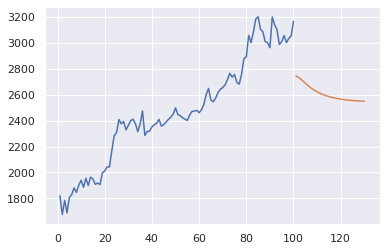

In [60]:
plt.plot(previous_days,scale.inverse_transform(test_data[83:]))
plt.plot(predicted_days,scale.inverse_transform(output))
plt.show()

Merging predicted data with previous data and ploting.

In [86]:
df3 = np.concatenate((np.array(data['Close']).reshape(-1,1), scale.inverse_transform(output)))

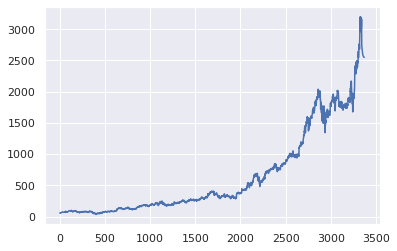

In [89]:
plt.plot(df3[2500:])
plt.show()